In [11]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch

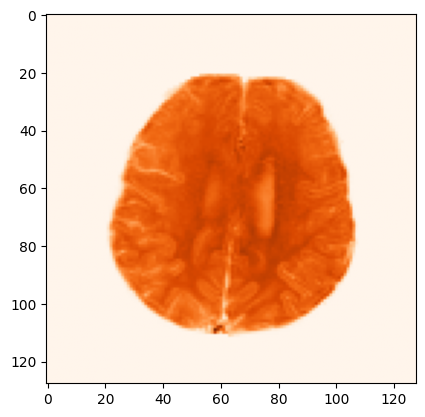

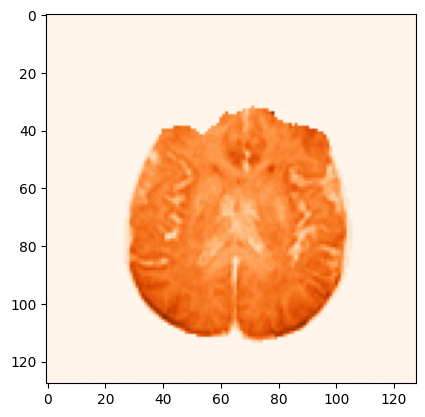

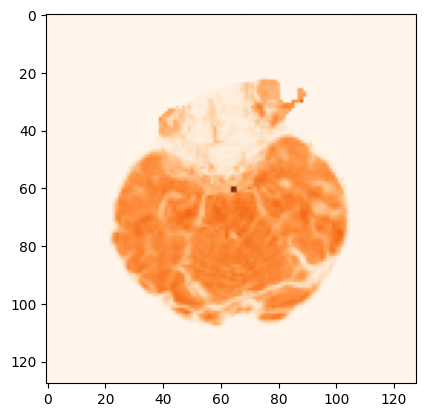

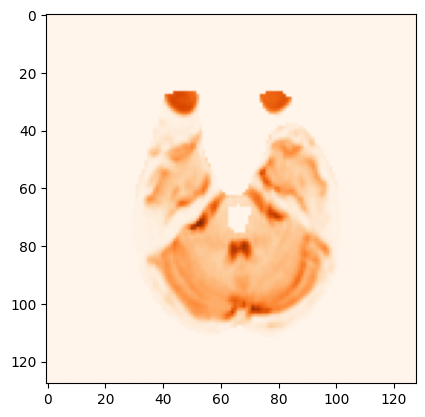

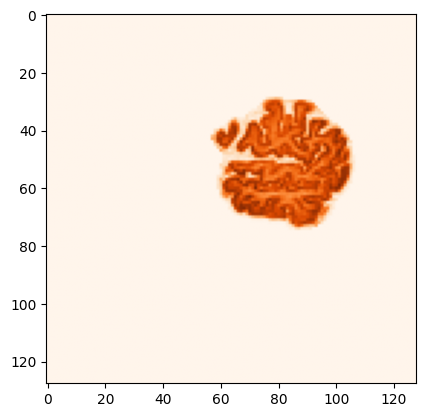

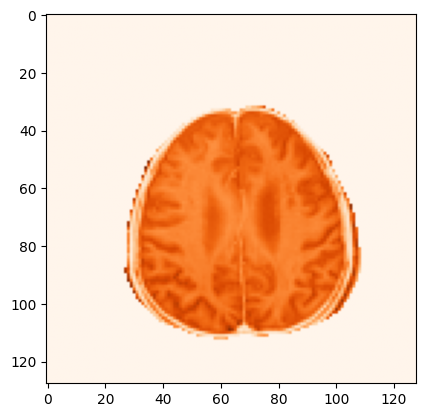

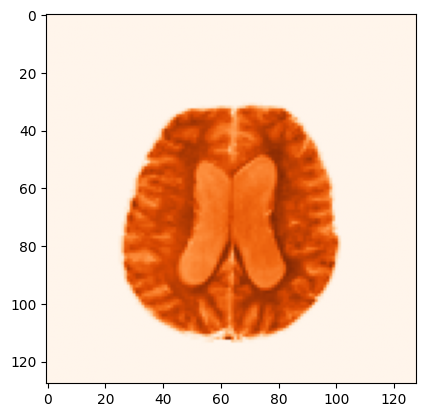

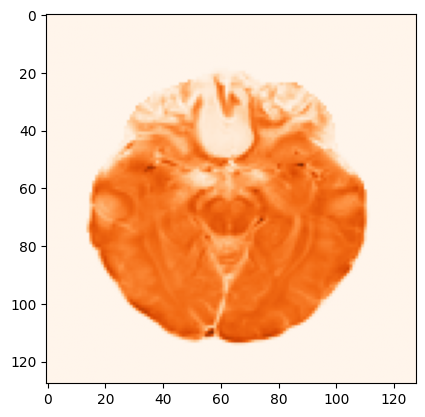

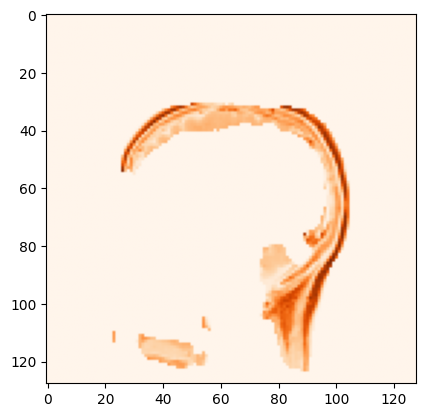

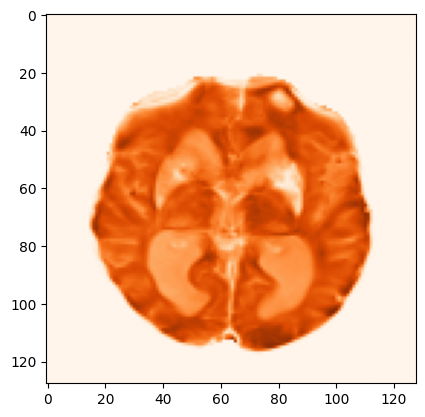

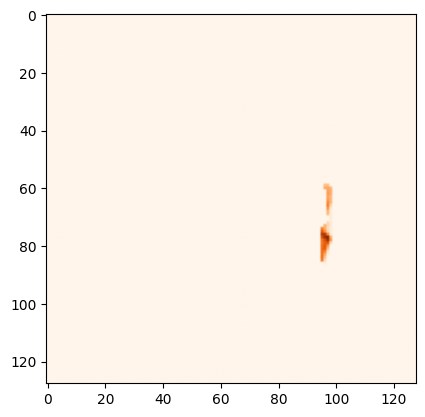

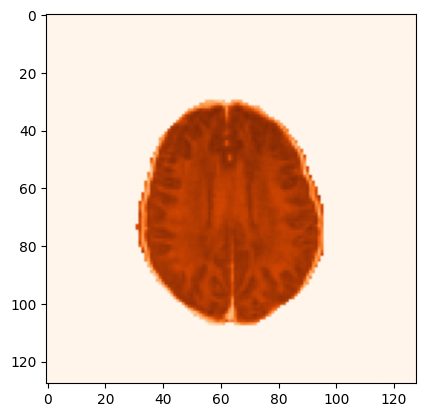

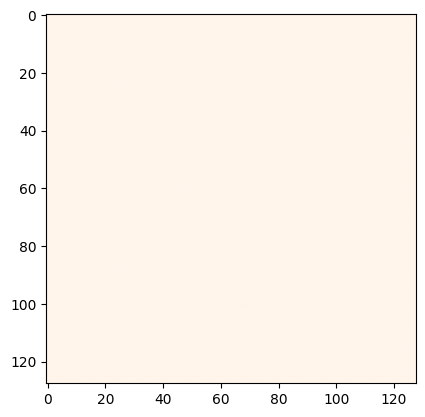

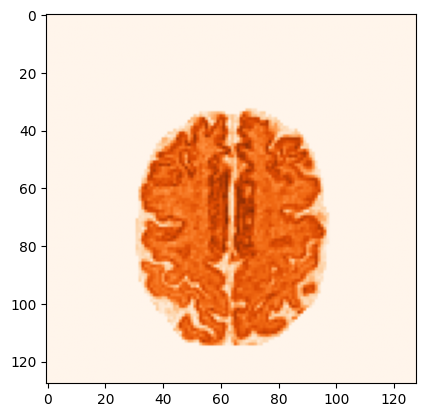

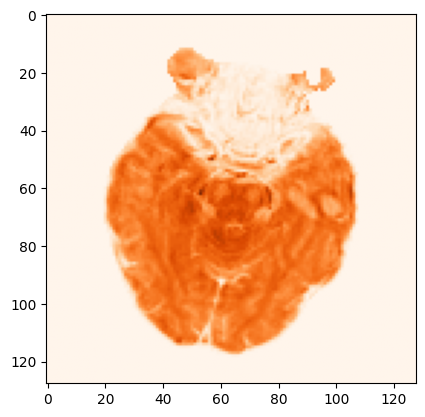

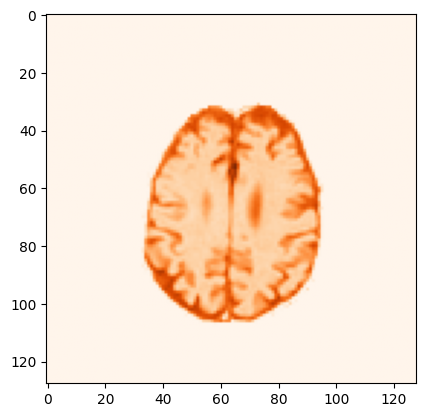

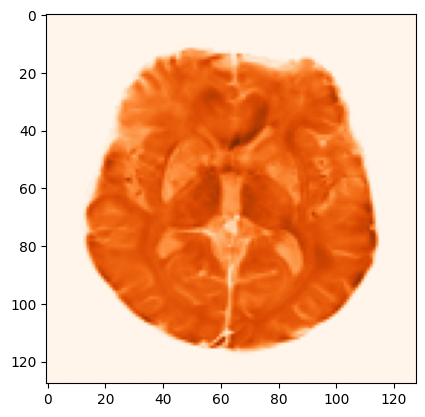

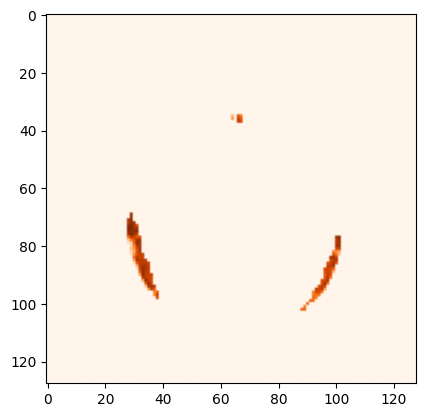

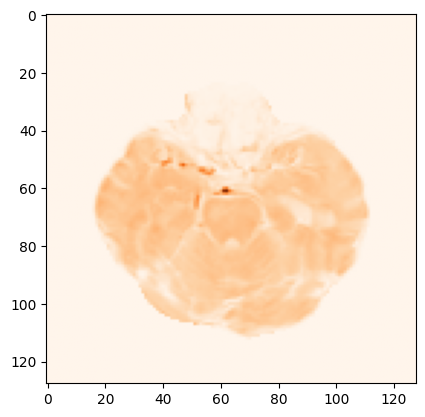

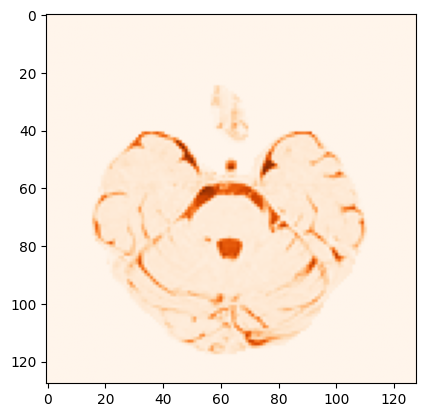

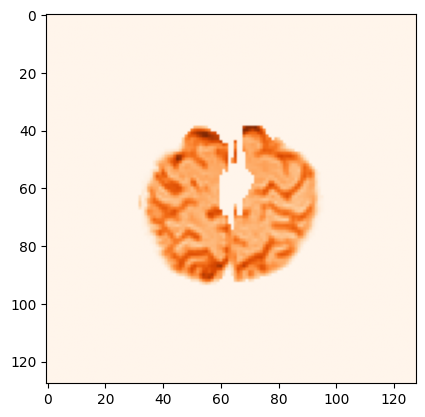

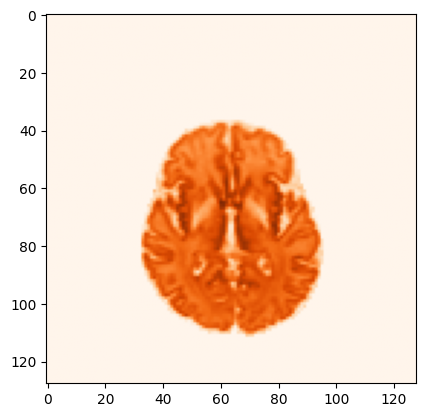

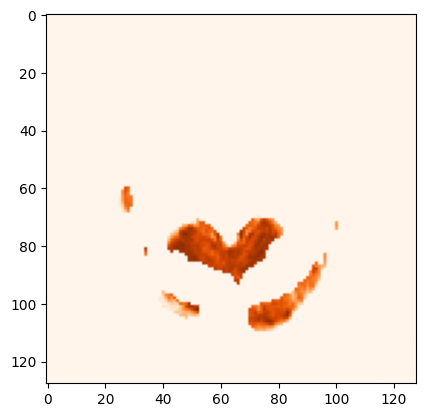

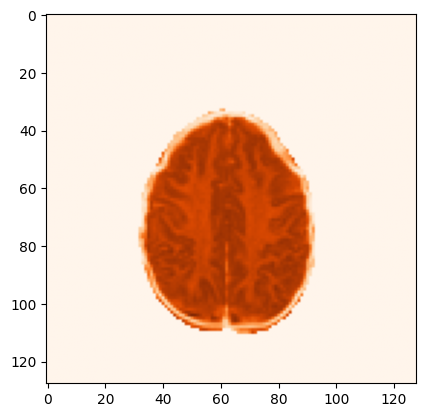

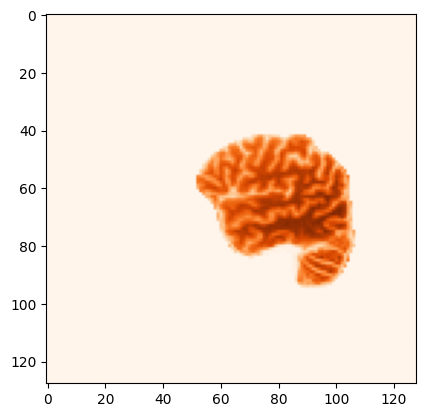

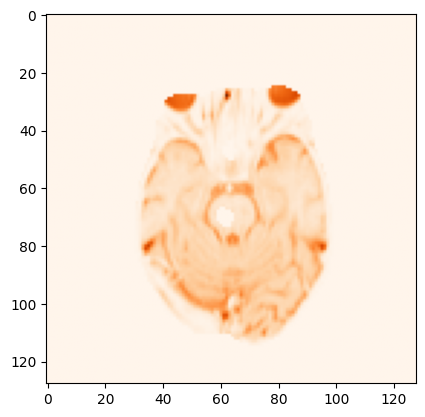

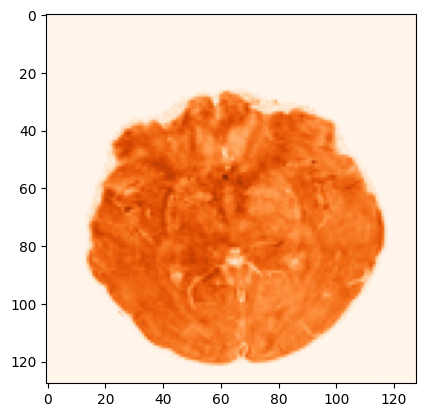

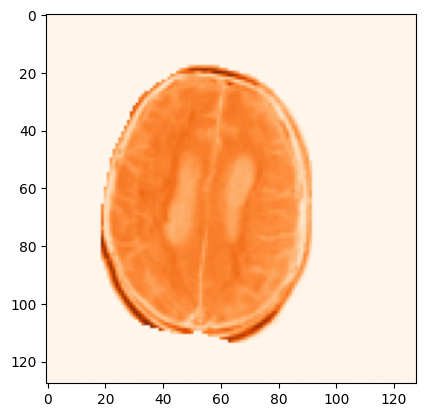

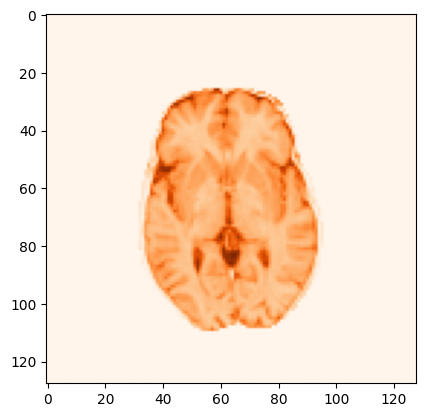

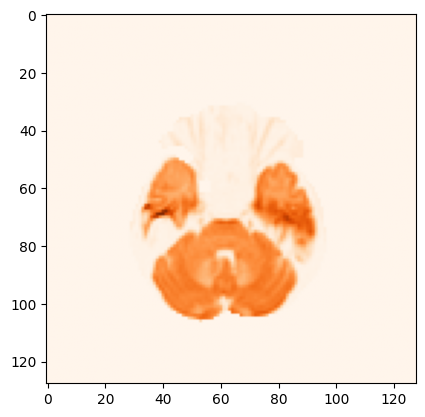

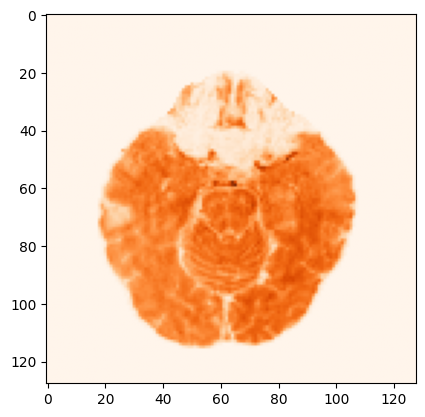

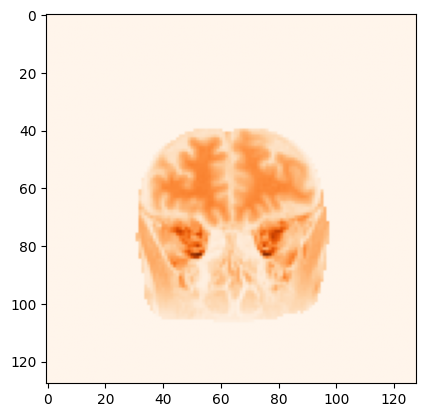

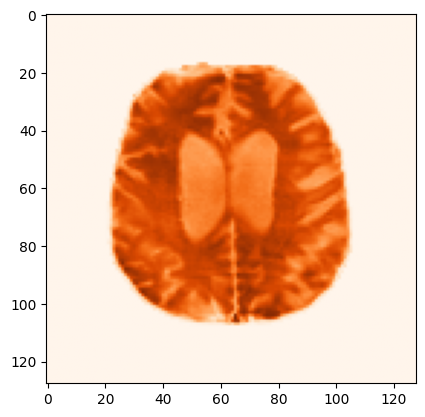

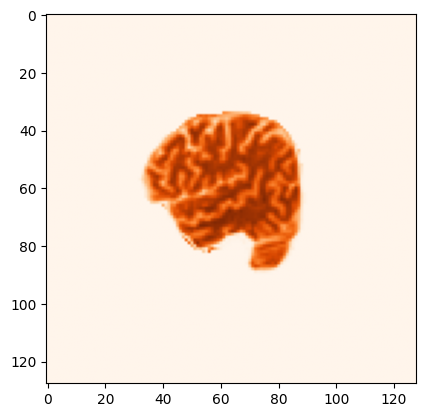

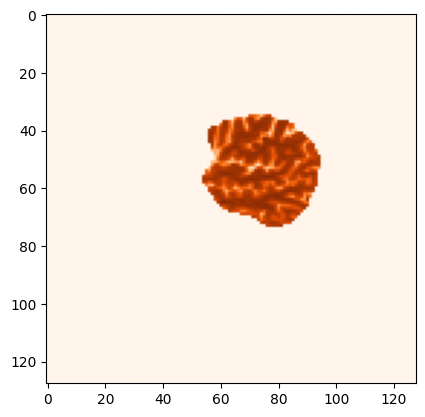

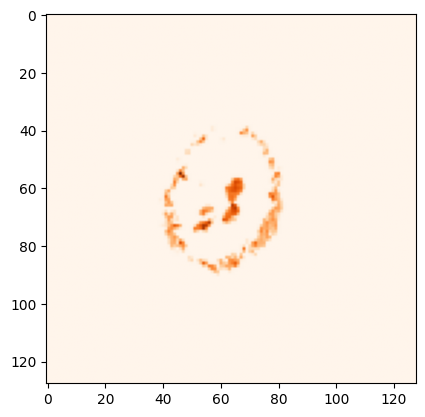

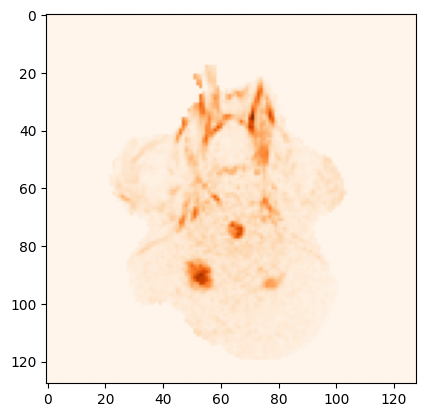

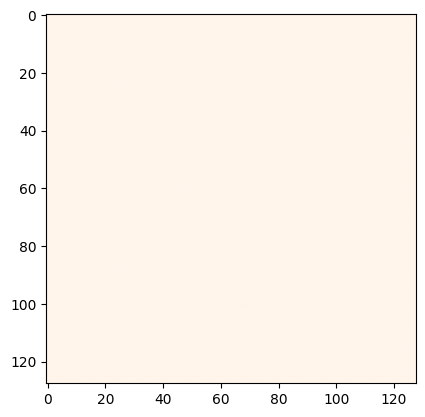

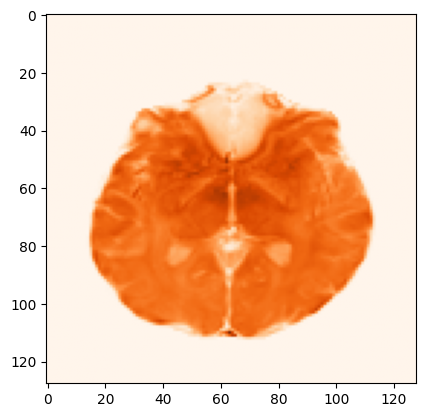

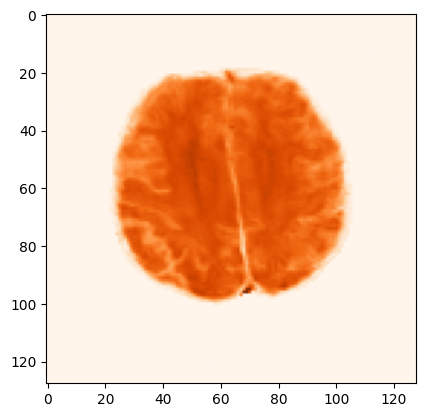

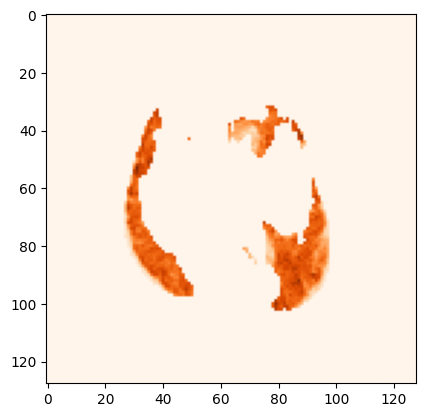

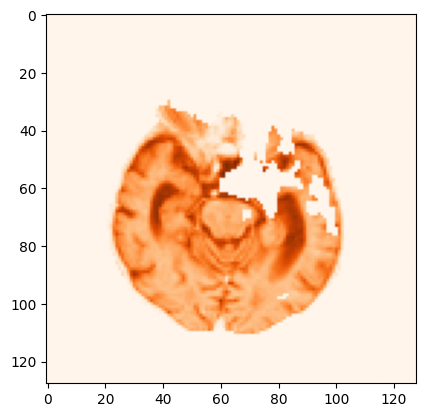

In [81]:
class Processing:
    def array_to_colour(self, array, cmap="Oranges"):
        '''
        Normalises data matrix for visualisation
        '''
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_clim(vmin=np.min(array), vmax=np.max(array)) # normalise cmap
        return sm.to_rgba(array)[:,:,:-1] # ignoring transparency

    def rgb_data_transform(data):
        '''
        to be used
        '''

        data_t = []
        for i in range(data.shape[0]):
            data_t.append(self.array_to_colour(data[i]).reshape(16,16,16,3))

        return np.asarray(data_t, dtype=np.float32)

    def load_all_imgs(self):
        '''
        Loading and visualising all images under a colour map
        '''
        for file in os.listdir("preprocessed_data"):
            if file.endswith(".npy"):
                data = np.load(f"preprocessed_data/{file}")[0] # all are (64, 128, 128)

                labels = self.get_labels(file)

                # cross section
                slice_idx = data.shape[0] // 2
                slice_2d = data[slice_idx, :, :]

                # converts 2D cross-section to RGB using cmap
                coloured_slice = self.array_to_colour(slice_2d)
                plt.imshow(coloured_slice)
                plt.show()

    def get_labels(self, file):
        file.split("_")

x = Processing()
x.load_all_imgs()

In [17]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import re

# Define the path to the pd-patients folder
base_path = "../ntua-parkinson-dataset/pd-patients"
pattern = r"^s\d+$"

# Loop through each subject folder (e.g., 0.DAT/s1, 0.DAT/s2, etc.)
for subject_folder in os.listdir(base_path):
    subject_path = os.path.join(base_path, subject_folder)

    if os.path.isdir(subject_path):
        print(f"Processing subject: {subject_folder}")

        # Loop through each .png file in the subject folder
        for scan_file in os.listdir(subject_path):
            if scan_file == "0.DAT":
                for s in os.listdir(os.path.join(subject_path, scan_file)):

                    if re.match(pattern, s): # matching only sY subdirs
                        for img in os.listdir(os.path.join(subject_path, scan_file, s)):
                            curr_dir = os.path.join(subject_path, scan_file, s, img)
                            if img.endswith(".png"):
                                plt.imshow(Image.open(curr_dir))


                        # Load and display the image
                        # img = np.asarray(Image.open(scan_path))
                        # plt.imshow(img)
                # plt.figure(figsize=(5, 5))
                # plt.imshow(img, cmap="hot")  # 'hot' colormap is often used for SPECT/PET scans
                # # plt.title(f"Subject: {subject_folder}, Scan: {scan_file}")
                # # plt.axis("off")
                # plt.show()

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '../ntua-parkinson-dataset/pd-patients'

In [84]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import confusion_matrix

# load data
X, y = [], []
for file in os.listdir("preprocessed_data"):
    if file.endswith(".npy"):
        label = int(file.split("_")[3])  # from e.g. ..._label_0_stripped.npy
        vol = np.load(os.path.join("preprocessed_data", file))  # shape: (1, D, H, W)
        X.append(vol)
        y.append(label)

# horizontal flip along width axis (W = axis 3)
X_aug = []
y_aug = []
for i in range(len(X)):
    flipped = np.flip(X[i], axis=3)  # width flip
    X_aug.append(flipped)
    y_aug.append(y[i])

X = np.concatenate([X, np.array(X_aug)])
y = np.concatenate([y, np.array(y_aug)])

# flip vertically (height axis)
X_flip_v = [np.flip(x, axis=2) for x in X]
y_flip_v = y.copy()

# add Gaussian noise
X_noise = [x + np.random.normal(0, 0.01, x.shape) for x in X]
y_noise = y.copy()

# merge all
X = np.concatenate([X, np.array(X_flip_v), np.array(X_noise)])
y = np.concatenate([y, np.array(y_flip_v), np.array(y_noise)])

X = np.array(X)
y = np.array(y)

# normalize
X = (X - np.mean(X)) / np.std(X)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# sample weights
class_sample_count = np.array([np.sum(y_train == t) for t in np.unique(y_train)])
weights = 1. / class_sample_count
sample_weights = weights[y_train]  # assign weight to each sample
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


# dataloader
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=2,
    sampler=sampler  # no shuffle needed
)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=2)

# 3D CNN (small)
class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(4)
        self.conv2 = nn.Conv3d(4, 8, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(8)
        self.conv3 = nn.Conv3d(8, 16, 3, padding=1)
        self.bn3 = nn.BatchNorm3d(16)
        self.pool = nn.MaxPool3d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 8 * 16 * 16, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

# setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Improved3DCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# train
for epoch in range(10):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1} | Loss: {total_loss / len(train_loader):.4f}")

# test

model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# accuracy & confusion matrix
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = np.mean(y_pred == y_true)

print(f"Test Accuracy: {accuracy:.2%}")
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

Epoch 1 | Loss: 0.7389
Epoch 2 | Loss: 0.6468
Epoch 3 | Loss: 0.5990
Epoch 4 | Loss: 0.4960
Epoch 5 | Loss: 0.3942
Epoch 6 | Loss: 0.3777
Epoch 7 | Loss: 0.3755
Epoch 8 | Loss: 0.2782
Epoch 9 | Loss: 0.2947
Epoch 10 | Loss: 0.2760
Test Accuracy: 90.20%
Confusion matrix:
 [[12  0]
 [ 5 34]]
